<a href="https://colab.research.google.com/github/vkay47/ADSC_2110_Flask-Application/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. PyTorch Classification Exercises

The following is a template for 02. PyTorch Classification exercises.

It's only starter code and it's your job to fill in the blanks.

Because of the flexibility of PyTorch, there may be more than one way to answer the question.

Don't worry about trying to be *right* just try writing code that suffices the question.

## Resources
* These exercises are based on [notebook 02 of the learn PyTorch course](https://www.learnpytorch.io/02_pytorch_classification/).
* You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [45]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors.
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [46]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=1000, random_state=42, noise=0.08)

In [47]:
# Turn data into a DataFrame
import pandas as pd

df = pd.DataFrame(X, columns=["X1","X2"])
df["y"] = y
df.head()


,X1,X2,y
0,-0.039430,0.428994,1
1,1.009890,-0.435174,1
2,0.882359,-0.303504,1
3,0.324256,-0.428016,1
4,-0.836834,0.533269,0


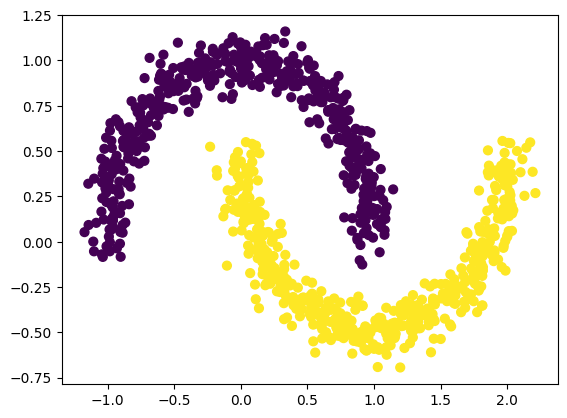

In [48]:
import matplotlib.pyplot as plt

# Visualize the data on a scatter plot

plt.scatter(X[:,0],X[:,1],c=y,s=40)
plt.show()


In [49]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [ ]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    ## Your code here ##

    def __init__(self,input_features,output_features,hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


# Instantiate the model

model = MoonModelV0(2,2).to(device)
model

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [51]:
# Setup loss function

loss_fn = nn.CrossEntropyLoss()

# Setup optimizer to optimize model's parameters

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [ ]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

In [ ]:
from torchmetrics import Accuracy


# What's coming out of our model?

torch.manual_seed(RANDOM_SEED)

epochs = 1000

# Send data to the device

X_train_tensor,X_test_tensor = X_train_tensor.to(device),X_test_tensor.to(device)

#Sending y target variable to the device

y_train_tensor,y_test_tensor = y_train_tensor.to(device),y_test_tensor.to(device)


# Loop through the data
for epoch in range(epochs):
  model.train()

  #Forward pass (logits output)

  y_logits = model(X_train_tensor)

  #Turn logits into prediction probabilities
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  #Calculate the loss
  loss = loss_fn(y_logits,
                 y_train_tensor)

  #Calculate the accuracy
  acc = acc_fn(y_pred, y_train_tensor.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  #Zero the gradients
  optimizer.zero_grad()

  #Loss backward (perform backpropagation)
  loss.backward()

  #Step the optimizer (gradient descent)
  optimizer.step()

  ## Testing
  model.eval()
  with torch.inference_mode():
    #Forward pass (to get the logits)
    y_logits = model(X_test_tensor)

    #Turn the test logits into prediction labels
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    #Caculate the test loss/acc
    loss = loss_fn(y_logits, y_test_tensor)
    acc = acc_fn(y_pred, y_test_tensor)

  #Print out what's happening every 100 epochs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc}")



# logits (raw outputs of model)
y_logits = model(X_train_tensor)
print("Logits:")
print(y_logits)

# Prediction probabilities
probs = torch.softmax(y_logits, dim=1)

print("Pred probs:",probs)


# Prediction labels
print("Pred labels:",probs.argmax(dim=1))


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [58]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [63]:
# Plot decision boundaries for training and test sets


#Make predictions with your trained model and plot them using the plot_decision_boundary() function
plot_decision_boundary(model, X_train_tensor, y_train_tensor)


RuntimeError: shape '[101, 101]' is invalid for input of size 20402

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

In [64]:
# Create a straight line tensor
st_line= torch.arange(-10,10,1)
st_line

tensor([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   5,   6,   7,   8,   9])

In [65]:
# Test torch.tanh() on the tensor and plot it

tanh_tensor = torch.tanh(st_line)
tanh_tensor


tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993, -0.9951,
        -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,  0.9993,  0.9999,
         1.0000,  1.0000,  1.0000,  1.0000])

In [68]:
# Replicate torch.tanh() and plot it
def tanh_rep(x):
  return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))

tanh_rep(st_line)

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993, -0.9951,
        -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,  0.9993,  0.9999,
         1.0000,  1.0000,  1.0000,  1.0000])

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

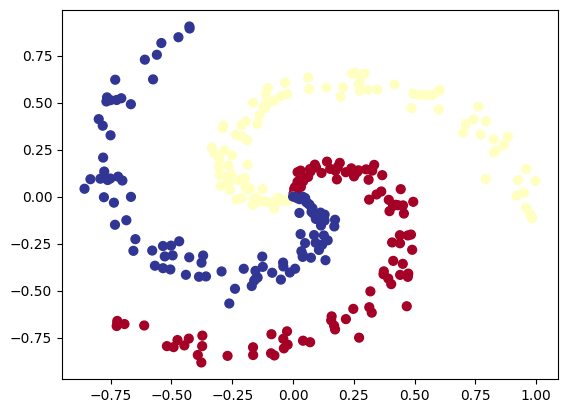

In [69]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [ ]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [70]:
# Let's calculuate the accuracy for when we fit our model


## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [85]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module

class SpiralModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


# Instantiate model and send it to device

model = SpiralModel(2,4).to(device)
model

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [107]:
# Setup data to be device agnostic
X_train_tensor,X_test_tensor = X_train_tensor.to(device),X_test_tensor.to(device)
y_train_tensor,y_test_tensor = y_train_tensor.to(device),y_test_tensor.to(device)


# Print out first 10 untrained model outputs (forward pass)

#forward pass
y_logits = model(X_train_tensor)

y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

print("Logits:"y-)

print("Pred probs:",y_preds[:10])
## Your code here ##

#print prediction labels

print("Pred labels:",y_preds[:10].argmax())

## Your code here ##

Logits:
Pred probs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Pred labels: tensor(0, device='cuda:0')


In [ ]:
# Setup loss function and optimizer
# loss_fn =
# optimizer =

In [ ]:
# Build a training loop for the model

# Loop over data


  ## Training

  # 1. Forward pass


  # 2. Calculate the loss


  # 3. Optimizer zero grad


  # 4. Loss backward


  # 5. Optimizer step


  ## Testing


    # 1. Forward pass

    # 2. Caculate loss and acc

  # Print out what's happening every 100 epochs


In [ ]:
# Plot decision boundaries for training and test sets
